# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [1]:
import numpy as np

class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        
        for n in self.inputs:
            n.outputs.append(self)
        
        self.value = None
        self.gradients = {}
        
    def forward(self):

        raise NotImplemented

    def backward(self):

        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):
        if value is not None:
            self.value = value
   
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1

class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)

    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  

            self.gradients[self.inputs[0]] = grad_cost * self.partial

class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])

    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)

    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

def forward_and_backward(outputnode, graph):

    for n in graph:
        n.forward()

    for n in  graph[::-1]:
        n.backward()

def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)

            if len(G[m]['in']) == 0:
                S.add(m)
    return L

def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [5]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))
losses = []

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):

        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        X.value = X_batch
        y.value = y_batch

        _ = None
        forward_and_backward(_, graph)

        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 219.698
Epoch: 101, Loss: 6.160
Epoch: 201, Loss: 5.121
Epoch: 301, Loss: 3.600
Epoch: 401, Loss: 3.964
Epoch: 501, Loss: 3.558
Epoch: 601, Loss: 3.471
Epoch: 701, Loss: 3.336
Epoch: 801, Loss: 3.414
Epoch: 901, Loss: 2.990
Epoch: 1001, Loss: 3.370
Epoch: 1101, Loss: 3.108
Epoch: 1201, Loss: 3.204
Epoch: 1301, Loss: 2.851
Epoch: 1401, Loss: 2.749
Epoch: 1501, Loss: 3.119
Epoch: 1601, Loss: 3.552
Epoch: 1701, Loss: 3.484
Epoch: 1801, Loss: 2.702
Epoch: 1901, Loss: 3.370
Epoch: 2001, Loss: 3.061
Epoch: 2101, Loss: 3.096
Epoch: 2201, Loss: 2.531
Epoch: 2301, Loss: 3.327
Epoch: 2401, Loss: 3.206
Epoch: 2501, Loss: 2.884
Epoch: 2601, Loss: 3.059
Epoch: 2701, Loss: 2.885
Epoch: 2801, Loss: 3.031
Epoch: 2901, Loss: 3.032
Epoch: 3001, Loss: 3.255
Epoch: 3101, Loss: 3.172
Epoch: 3201, Loss: 2.769
Epoch: 3301, Loss: 2.993
Epoch: 3401, Loss: 2.965
Epoch: 3501, Loss: 2.999
Epoch: 3601, Loss: 2.949
Epoch: 3701, Loss: 3.136
Epoch: 3801, Loss: 2.892
Epoc

In [6]:
import matplotlib.pyplot as plt

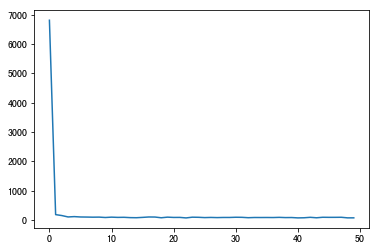

In [7]:
plt.plot(range(len(losses)), losses)

In [9]:
W2.value

array([[ 8.70992839],
       [ 7.48242354],
       [ 6.91915777],
       [-7.34729459],
       [ 9.12147477],
       [ 7.66648724],
       [ 8.72676133],
       [ 9.08555971],
       [ 7.32385634],
       [ 5.52420302]])

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

A neuron reseive inputs, make linear transformation and nonlinear transformation with the inputs, and at last last,output a converted digital。

A neuron computes with the inputs by two steps as what the following picture shows.

We assume that x is the inputs vector,such as $(x_1,x_2,x_3)$ , and there is a linear model: $w^Tx+b$ with parameters of w and b, and there is a nonlinear model named sigmoid function: $\sigma(z)=\frac{1}{1+e^{-z}}$.

**The first step:** a neuron make a matrix calculation: $w^Tx$ and add a bias value: b. Then we can get $z=w^Tx+b$.

**The second step:** input z into the sigmoid activation function: $\sigma(z)=\frac{1}{1+e^{-z}}$, and then output the value.

<img src="https://ftp.bmp.ovh/imgs/2019/11/586a796fc2a72c32.png"  height="150" width="200">

####  2. Why we use non-linear activation funcitons in neural networks?

If we choose a linear function such as $y=cx$ as activation function, we would find there are two main problems with this choice:

(1) the derivative of the function is a constant.For example, in $y=cx$,derivative with respect to x is c, which means the gradient has no relationship with x and is a constant. If there is an error in prediction, the changes made by back propagation are not depending on the change in input $\Delta(x)$.

(2) if each layer is activated by a linear function, no matter how many layers we have, the final activation function of last layer is nothing but just a linear function of the input of first layer. That means these N layers can be replaced by a single layer and stacking layers doesn't have any meaning.

However,if we choose a nonlinear activation function such as sigmoid function,  there are three main advantages :

(1) stacking layers is meaningful,because combinations of nonlinear function are also nonlinear.

(2) look at the image below, between X values -2 to 2,Y values is very steep, which means any changes in the value of X in that region will cause values of Y to change significantly. Therefore, it tends to bring the activations to either side of the curve, making clear distinctions on prediction.

(3) unlike linear function, the output of the sigmoid function is always going to be in range(0,1) compared to (-inf,inf). 

<img src ="https://s2.ax1x.com/2019/11/02/KqTWm4.png" height="150" width="200">


#### 3. What is the 'Logistic Loss' ?

### <center>The formula of Logistic Loss</center>

The loss function of logistic regression is called Logistic Loss. We use the formula below to calculate the logistic loss of one sample: 

<img src="https://s2.ax1x.com/2019/11/02/KLPxsJ.png" height="150" width="200">

<img src="https://s2.ax1x.com/2019/11/02/KqXJED.png" height="200" width="300">

If y=1, when prediction=1,the cost=0, when prediction=0, the learning algorithm is punished by a very large cost. Similarly, if y=0, predicting 0 has no punishment but predicting 1 has a large value of cost.

<img src="https://s2.ax1x.com/2019/11/02/KqxJET.png" height="200" width="300">

And although we are looking at the loss function by y=1 and y=0 seperately, it can be written as one single formula:

<img src="https://s2.ax1x.com/2019/11/02/KLC07q.png" height="250" width="350">

So the cost function of the model is the summation from all training samples:

<img src="https://s2.ax1x.com/2019/11/02/KLCo4K.png" height="250" width="350">

### <center> Why is Logistic Loss</center>

(1) Linear regression uses Least Squared Error as loss function, but Least Squared Error is not an option for logistic regression since this loss function will result in a non-convex graph with local minimums by calcalating with sigmoid function.

<img src="https://s2.ax1x.com/2019/11/02/KLC3AP.md.png" height="250" width="350">

(2) Logistic loss can assign more punishment when predicting 1 while the actual is 0 and when predict 0 while the actual is 1.

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

I choose C: sigmoid.

I recommend using sigmoid function for the output layer,because the output of it is in range(0,1) which can be regarded as the probability of the category we want to predict.

The sigmoid functions works well for a classifier.Let's look at the curve of sigmoid function, the value of $h_\theta(x)$ is 0.5 when x=0. Therefore we can set rules for our classifier,such as: if the output is larger than or equal to 0.5, predict 1; if the output is smaller than 0.5, predict 0. 

The tanh function is bound to range(-1,1) and relu function gives an output x if x is possitive and 0 otherwise. Their outputs are not so convenient for classifying directly.

#### 5. Why we don't use zero initialization for all parameters ?

If we use zero initialization for all parameters then every hidden unit will get zero independent of the input. So, when all the hidden neurons start with the zero weights, then all of them will follow the same gradient and it affects only the scale of the weight vector, not the direction.

Also, having zero weights to start with will prevent the network from learning. The errors backpropagated through the network is proportional to the value of the weights. If all the weights are the same, then the backpropagated errors will be the same, and consequently, all of the weights will be updated by the same amount.

So all of the neurons will end up with the same value and it will be no different that having just one neuron in the hidden layer. Because of this, our network will end up learning just one function while the goal of a neural network is to have different neurons compute different functions. This is called the "Symmetry Problem."

In order to avoid the "Symmetry Problem", we initialize the weights randomly.

#### 6. Can you implement the softmax function using python ? 

Softmax function is generally used for output layer for multi-classifier in neural networks. 

Assuming that in a multi-classification problem, we need to classifier the dataset into C categories. One training sample is $x=(x_1,x_2,...,x_n)$ which has n features. 

If the weight vector of the class c (c=1,2,...C) is $w_c$, then the probability of x be predicted as class c is: 

<img src="https://s2.ax1x.com/2019/11/02/KLenc6.png" height="200" width="300">

Therefore, we can get C probabilities: $p_1,p_2,...,p_C$ corresponding to C catetories, and if $p_3$ is the maximum, then we predict x is in the third class.

Python code:

In [3]:
import numpy as np

def softmax(x):
    """
    :x: x is not the sample,but the product of 
        sample and weight value.
    """
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

softmax([1,5,3,2,7])

array([0.00213159, 0.11638064, 0.01575041, 0.00579425, 0.85994311])

In [4]:
def softmax_max(x):
    """
    according to another formula
    """
    x = x - np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

softmax_max([1,5,3,2,7])

array([0.00213159, 0.11638064, 0.01575041, 0.00579425, 0.85994311])

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [4]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [5]:
# Loading the data 
digits = datasets.load_digits()

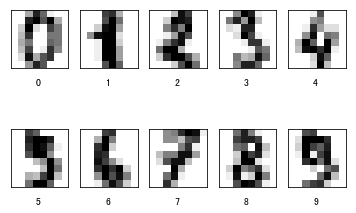

In [6]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [7]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [8]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


#### 3- Architecture of the neural network

![title](network.png)

In [10]:
!pwd

/home/msg/nlp第五期课程/2019-autumn/nlp_course_assignment/第4次课作业


##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [11]:
"""
输入为标量或者任意维度的numpy数组，要得到所有数字的sigmoid；
就分为标量和数组两种情况考虑，判断输入为标量时直接返回sigmoid；
判断输入为数组时，用递归来做，递归的终止条件设定为z是一维数组。
"""

def sigmoid(z):
    '''
    Compute the sigmoid of z.
    ------------------------
    z: input, a scalar or numpy array of any size.
    s: return, sigmoid(z)
    -----------------------
    '''
    
    def sigmoid_one(z_i):
        sigmoid = 1./ (1 + np.exp(-z_i))
        return round(sigmoid,8)
    
    if isinstance(z,(int,float)):
        s = sigmoid_one(z)
      
    elif isinstance(z,np.ndarray):   
        if z.ndim == 1:
            s = list(map(sigmoid_one,z))
        else:
            s = []
            for i in range(z.shape[:-1][0]):
                s.append(sigmoid(z[i]))
    
    return s

In [12]:
"""
Test your code 
The result should be [0.5 0.88079708]
"""
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5, 0.88079708]


In [13]:
test_sigmoid = np.random.randint(10,size=(2,3,4))
test_sigmoid

array([[[7, 2, 5, 2],
        [5, 2, 3, 0],
        [8, 6, 0, 5]],

       [[5, 8, 3, 5],
        [9, 3, 2, 7],
        [6, 2, 2, 0]]])

In [14]:
from pprint import pprint
pprint(sigmoid(test_sigmoid))

[[[0.99908895, 0.88079708, 0.99330715, 0.88079708],
  [0.99330715, 0.88079708, 0.95257413, 0.5],
  [0.99966465, 0.99752738, 0.5, 0.99330715]],
 [[0.99330715, 0.99966465, 0.95257413, 0.99330715],
  [0.99987661, 0.95257413, 0.88079708, 0.99908895],
  [0.99752738, 0.88079708, 0.88079708, 0.5]]]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [15]:
"""
Random innitialize the parameters
这里的w和b都是指一个神经元上的参数，而不是整个隐藏层的参数
所以w的维度是(dim,1),dim是上一层的神经元个数。
"""
import random

def initialize_parameters(dim):
    '''
    Argument: 
    dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.randn(dim,1)
    b = random.random()
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,(int,float)))
    
    return w,b

In [16]:
w,b = initialize_parameters(10)
print(w)
print()
print(b)

[[ 0.0216597 ]
 [ 0.34063383]
 [ 0.06671504]
 [-0.23358625]
 [ 1.34047174]
 [-0.54998018]
 [-0.68933264]
 [-0.62369588]
 [-0.01751757]
 [ 2.16023216]]

0.7221905177789257


#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [17]:
"""
X是batch-size个样本，所以维度为(batch-size,d),d是特征维度
w，b是一个神经元上的参数;
计算cost时，由于a等于0或者1时，log(a)或log(1-a)是 -inf，导致cost为nan
所以把A中的0和1去掉，再计算cost。
在原作业代码里，m=X.shape[1]，可是对比上面的X_train的维度(1647,64),
样本的个数m应该是X.shape[0],所以做了修改。
"""

def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[0]
    A = np.squeeze(sigmoid(np.dot(X,w)-b))
    
    '''把A中的0和1去掉，再计算cost'''
    cost = - np.mean([y*np.log(a) + (1-y)*np.log(1-a) for y,a in zip(Y,A) if a*(1-a) != 0])
    cost = round(cost,8)
    
    dw = (1/m * np.dot(X.T,(A-Y))).reshape(-1,1)
    db = np.mean(A - Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

In [18]:
"""
用训练数据测试一下计算损失和梯度的函数
"""
w,b = initialize_parameters(64)
grads, cost = propagate(w, b, X_train, y_train)
print("Gradient: \n{}".format(grads))

Gradient: 
{'dw': array([[ 0.00000000e+00],
       [-2.75696547e-02],
       [-1.15806168e+00],
       [-3.54435047e+00],
       [-4.14531741e+00],
       [-2.76850372e+00],
       [-9.29425074e-01],
       [-8.54489389e-02],
       [-1.47900855e-03],
       [-2.01558673e-01],
       [-3.10227969e+00],
       [-3.68809090e+00],
       [-2.38033716e+00],
       [-2.93869507e+00],
       [-1.00186706e+00],
       [-5.55979429e-02],
       [ 2.22702131e-03],
       [-5.31274918e-01],
       [-3.50613302e+00],
       [-1.66502640e+00],
       [-7.13186223e-01],
       [-2.81136145e+00],
       [-6.73019803e-01],
       [-1.00652362e-02],
       [ 1.48478091e-03],
       [-6.91813780e-01],
       [-3.80739644e+00],
       [-3.34343604e+00],
       [-2.79057605e+00],
       [-3.20539771e+00],
       [-8.66157988e-01],
       [ 5.71863400e-08],
       [ 0.00000000e+00],
       [-6.07101819e-01],
       [-3.36514022e+00],
       [-3.69403845e+00],
       [-3.20805669e+00],
       [-3.57048886e

In [19]:
print("Cost: \n{}".format(cost))

Cost: 
5.25657615


##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [20]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(1,num_iterations+1):
        
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

In [21]:
w,b = initialize_parameters(64)
params,grads,costs = optimize(w,b,X_train,y_train,500,1e-2,True)

Cost after iteration 100: 2.878378
Cost after iteration 200: 2.036022
Cost after iteration 300: 1.571014
Cost after iteration 400: 1.281823
Cost after iteration 500: 1.026358


###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [22]:
"""
还是根据我们用到的数据集，对原来的代码进行了修改。
"""

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[0]
    Y_prediction = np.zeros((1,m))
    
    A = np.squeeze(sigmoid(np.dot(X,w)+b))
    
    '''逻辑回归得到的概率大于0.5，就判定label为1，否则为0'''
    A_map = list(map(lambda x:1 if x>0.5 else 0,A)) 
    
    Y_prediction = np.array(A_map).reshape(1,-1)
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

In [23]:
w,b = params["w"],params["b"]

In [24]:
Y_prediction = predict(w,b,X_train)
print(" Y predicted is {}".format(Y_prediction))

 Y predicted is [[1 1 1 ... 1 0 0]]


##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [25]:
"""
训练模型并进行预测
"""

def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    w,b = initialize_parameters(X_train.shape[1])
    params,grads,costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    w_best,b_best = params["w"],params["b"]
    
    def calc_acc(Y,Y_pred):
        accuracy = np.mean([int(y==y_pred) for y,y_pred in zip(Y,Y_pred)])
        return round(accuracy,8)
    
    Y_train_pred = np.squeeze(predict(w_best,b_best,X_train))
    Y_test_pred = np.squeeze(predict(w_best,b_best,X_test))
    
    traing_accuracy = calc_acc(Y_train,Y_train_pred)
    test_accuracy = calc_acc(Y_test,Y_test_pred)
    
    d = {"w":w_best,
         "b":b_best,
         "training_accuracy": traing_accuracy,
         "test_accuracy":test_accuracy,
         "cost":costs}
    return d

In [26]:
result = model(X_train, y_train, X_test, y_test, 1500, 1e-2,True)

Cost after iteration 100: 3.658237
Cost after iteration 200: 2.943609
Cost after iteration 300: 2.510286
Cost after iteration 400: 2.029937
Cost after iteration 500: 1.543466
Cost after iteration 600: 1.246572
Cost after iteration 700: 1.056997
Cost after iteration 800: 0.947011
Cost after iteration 900: 0.871605
Cost after iteration 1000: 0.772370
Cost after iteration 1100: 0.700878
Cost after iteration 1200: 0.642563
Cost after iteration 1300: 0.595416
Cost after iteration 1400: 0.554114
Cost after iteration 1500: 0.520330


In [27]:
print("Training accuracy is :{}".format(result['training_accuracy']))
print("Test accuracy is :{}".format(result['test_accuracy']))
print("Cost of last iteration is :{}".format(result['cost'][-1]))

Training accuracy is :0.87899035
Test accuracy is :0.87777778
Cost of last iteration is :0.5203297


### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

In [35]:
learning_rates = np.linspace(1e-2,1e-1,10,endpoint=True)
learning_rates

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

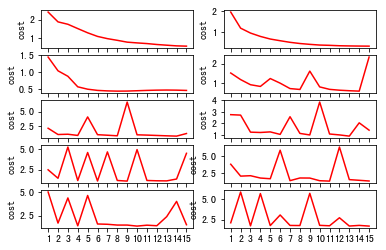

In [63]:
"""
从下图可以看到，当learning rate = 0.01或0.02时，
cost的curve比较平滑，稳定地下降；
而learning rate 增大时，cost的变化变得不稳定，
所以learning rate 不能取太大。
"""
for i,rate in enumerate(learning_rates):
    plt.subplot(5,2,i+1)
    result = model(X_train, y_train, X_test, y_test,1500,rate,False)
    costs = result['cost']
    iterations = list(range(1,1500//100+1))
    
    plt.plot(iterations,costs,color='red')
    
    plt.ylabel("cost")
    plt.xticks(iterations)
plt.show()

##### 4.2 Observe the effect of iteration_num on the test accuracy.

In [30]:
iteration_list = list(range(200,2100,100))

test_acc_list = []
for iteration in iteration_list:
    result = model(X_train, y_train, X_test, y_test, iteration, 1e-2,False)
    test_acc = result['test_accuracy']
    print("When iteration is {} \nTest accuracy is {}.\n".format(iteration,test_acc))
    test_acc_list.append(test_acc)

When iteration is 200 
Test accuracy is 0.75777778.

When iteration is 300 
Test accuracy is 0.84444444.

When iteration is 400 
Test accuracy is 0.81333333.

When iteration is 500 
Test accuracy is 0.77333333.

When iteration is 600 
Test accuracy is 0.81777778.

When iteration is 700 
Test accuracy is 0.84444444.

When iteration is 800 
Test accuracy is 0.83111111.

When iteration is 900 
Test accuracy is 0.85333333.

When iteration is 1000 
Test accuracy is 0.85777778.

When iteration is 1100 
Test accuracy is 0.83333333.

When iteration is 1200 
Test accuracy is 0.86222222.

When iteration is 1300 
Test accuracy is 0.83555556.

When iteration is 1400 
Test accuracy is 0.84444444.

When iteration is 1500 
Test accuracy is 0.85111111.

When iteration is 1600 
Test accuracy is 0.86888889.

When iteration is 1700 
Test accuracy is 0.85333333.

When iteration is 1800 
Test accuracy is 0.85111111.

When iteration is 1900 
Test accuracy is 0.83777778.

When iteration is 2000 
Test accurac

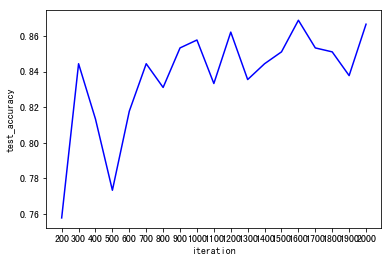

In [38]:
plt.plot(iteration_list,test_acc_list,color='blue')
plt.xlabel("iteration")
plt.ylabel("test_accuracy")

plt.xticks(iteration_list)
plt.show()

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digits (0,1,2,3,4,5,6,7,8,9) is in the image.

# Congratulations ! You have completed assigment 4. 